<a href="https://colab.research.google.com/github/gqmv/8queens/blob/main/8rainhas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [62]:
!pip install blackcellmagic
%load_ext blackcellmagic
import numpy as np
import pandas as pd
import seaborn as sns
import random
from tqdm import tnrange

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


# Classes and useful functions

In [63]:
class Individual:
    """
    A class that represents an individual.

    Attributes:
        internal_rep: the representation of the board as a list of integers
        matrix_rep: the matrix representation of the board, where each value
        represents a square of the board and can be 0 or 1, depending on whether
        the square is empty or not.
    """

    def __init__(self, array):
        """
        Initializes an instance of the individual.

        :param array: the representation of the board as a permutation.
        """
        if not isinstance(array, np.ndarray):
            raise TypeError("The array must be a ndarray")

        if len(array) != 8:
            raise ValueError("The array must have 8 elements")

        for element in array:
            if not isinstance(element, np.int64) or element < 0 or element > 7:
                raise ValueError("The array must contain only integers between 0 and 7")

        self._matrix_rep = None

        self._fitness = None

        self._internal_rep = None
        self.internal_rep = array


    @property
    def internal_rep(self):
        """
        Returns the internal representation of the board.

        :return: The internal representation of the board.
        """
        return self._internal_rep

    @internal_rep.setter
    def internal_rep(self, array):
        """
        Sets the internal representation of the board.

        :param value: The new internal representation of the board.
        """
        if not isinstance(array, np.ndarray):
            raise TypeError("The array must be a ndarray")

        if len(array) != 8:
            raise ValueError("The array must have 8 elements")

        for element in array:
            if not isinstance(element, np.int64) or element < 0 or element > 7:
                raise ValueError("The array must contain only integers between 0 and 7")

        self._internal_rep = array
        self._matrix_rep = [
            [0 if i != pos else 1 for i in range(8)] for pos in self.internal_rep
        ]
        self._fitness = self.__calculate_fitness()

    @property
    def matrix_rep(self):
        """
        Returns the matrix representation of the board.

        :return: The matrix representation of the board.
        """
        return self._matrix_rep

    @matrix_rep.setter
    def matrix_rep(self, value):
        """
        This function exists only to prevent writing to the matrix representation.
        """
        raise AttributeError("'Individual' object attribute 'matrix_rep' is read-only")

    @property
    def fitness(self):
        """
        Returns the fitness of the individual.

        :return: The fitness of the individual.
        """
        return self._fitness

    @fitness.setter
    def fitness(self, value):
        """
        This function exists only to prevent writing to the fitness.
        """
        raise AttributeError("'Individual' object attribute 'fitness' is read-only")

    def __calculate_conflicts(self, x, y):
        """
        Calculates the conflicts a specific queen.

        :param x: The x coordinate of the queen.
        :param y: The y coordinate of the queen.
        :return: The number of conflicts of the queen.
        """
        matrix = self.matrix_rep
        conflict = 0
        for i in range(8):
            for j in range(8):
                if matrix[i][j] == 1 and i != x and j != y:
                    if abs(x - i) == abs(y - j):
                        conflict = conflict + 1
        return conflict

    def __calculate_fitness(self):
        """
        Calculates the fitness of the individual.

        :return: The fitness of the individual.
        """
        fitness = 0
        matrix = self.matrix_rep
        for i in range(8):
            for j in range(8):
                if matrix[i][j] == 1:
                    fitness += self.__calculate_conflicts(i, j)
        return fitness
    
    def __str__(self):
        output = ""
        for i in range(len(self.internal_rep)):
            for j in range(len(self.internal_rep)):
                if self.internal_rep[i] == j:
                    output += "Q "
                else:
                    output += ". "
            output += "\n"
            
        return output

In [64]:
class Population:
    def __init__(self, size): 
        self.size = size
        self.individuals = []

        for _ in range(size):
            permutation = np.random.permutation(8)
            self.individuals.append(Individual(permutation))


In [65]:
def int_to_array(i):
    """
    This function receives an integer and returns a list of all the digits on the int
    :param i: The integer to be arrayed
    :return: The array of digits
    """
    
    temp = i
    answ = []
    while (temp>0):
      digit = temp % 10
      answ.append(digit)
      temp = int(temp/10)
    return answ
  

def de_binarize(son):
    """
    This function receives a binary array and returns a array with decimal numbers

    :param son: array made of binary numbers
    :return de_binarized_array: array of decimal integers
    """
    de_binarized_array = []
    for number in son:
      son_digits = int_to_array(number)
      de_bin_son_digit = 0
      for i, d in enumerate(son_digits):
        de_bin_son_digit+= d*2**i
      de_binarized_array.append(de_bin_son_digit)
    return np.array(de_binarized_array)
  

def binarize (parent):
    """ 
    This function return the binarized array representing a individual

    :param parent: the individual to have a array binazrized
    :return: the binarized array
    """
    binarized = []
    for i in parent.internal_rep:
      b = int(bin(i)[2:])
      binarized.append(b)
    
    return binarized


In [66]:
def select_parents(pop):
    """
    This function selects the parents for an individual.

    :param pop: The population to select the parents from.
    :return: The parents.
    """
    possible_parents = np.random.choice(pop.individuals, 3)
    possible_parents = sorted(possible_parents, key=lambda x: x.fitness)
    
    return possible_parents[0], possible_parents[1]

def crossover (p1, p2):
    """
    This function makes the crossover of two parents.

    :param p1: The first parent.
    :param p2: The second parent.
    :return: The two generated sons
    """

    #First we binarize the parents
    binarized_p1 = binarize(p1)
    binarized_p2 = binarize(p2)

    #Then we perform the crossover algorithm
    son1 = binarized_p1[:4]
    son2 = binarized_p2[:4]

    #Since we want to start the crossover from the middle of the array, we create a new array to iterate over
    c_binarized_p1 = np.append(binarized_p1[4:],(binarized_p1[:4]))
    c_binarized_p2 = np.append(binarized_p2[4:],(binarized_p2[:4]))

    for i, (pos1, pos2) in enumerate (zip(c_binarized_p1, c_binarized_p2)):
      if not (pos2 in son1):
        son1.append(pos2)
      if not (pos1 in son2):
        son2.append(pos1)
    #Now we de-binarize the sons vectors, and return them
    son1 = Individual(np.array(de_binarize(son1)))
    son2 = Individual(np.array(de_binarize(son2)))
    return son1, son2
  

def mutate(individual):
    """
    This function mutates an individual.

    :param individual: The individual to mutate.
    """
    binarized_individual = binarize(individual)
    pos1 = np.random.randint(0, len(binarized_individual) - 1)
    pos2 = np.random.randint(0, len(binarized_individual) - 1)
    
    while (pos1 == pos2):
        pos2 = np.random.randint(0, len(binarized_individual) - 1)
    
    binarized_individual[pos1], binarized_individual[pos2] = binarized_individual[pos2], binarized_individual[pos1]
    
    individual.internal_rep = de_binarize(binarized_individual)
    return individual


In [67]:
def evolve(pop, epochs, p_crossover, p_mutation):
    """
    This function evolves the population for a given number of epochs.

    :param pop: The population to evolve.
    """
    for epoch in range (epochs):
        best_individual = max(pop.individuals, key=lambda x: x.fitness)
        if best_individual.fitness == 0:
          return best_individual, epoch

        #Select Parents
        p1, p2 = select_parents(pop)
        #First, the two sons are equal to their parents
        s1, s2 = p1, p2
        #Crossover
        if(random.randint(1,10)/10>p_crossover):
          s1, s2 = crossover(p1,p2)
        #Mutation
        if(random.randint(1,10)/10>p_mutation):
          s1, s2= mutate(s1), mutate(s2)
        #Replacement ?
        new_pop = pop.individuals + [s1, s2]
        
        new_pop = sorted(new_pop, key=lambda x: x.fitness)
        new_pop = new_pop[:pop.size]
        pop.individuals = new_pop
    return None, epochs

# Demonstrating the evolution

In [68]:
pop = Population(100)
print(evolve(pop, 10000, 0.9, 0.4))

(<__main__.Individual object at 0x7f7bba80ffd0>, 761)


# Analyzing results

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  after removing the cwd from sys.path.


  0%|          | 0/1000 [00:00<?, ?it/s]

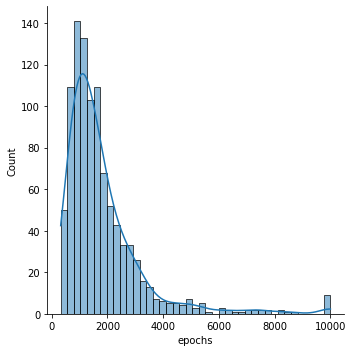

In [70]:
df = pd.DataFrame(data = {"epochs": []})

SAMPLE_SIZE = 1000
for _ in tnrange(SAMPLE_SIZE):
  pop = Population(100)
  ind, epochs = evolve(pop, 10000, 0.9, 0.4)
  df2 = pd.DataFrame(data = {"epochs": [epochs]})
  df = pd.concat([df, df2], ignore_index = True)

sns.displot(data=df, x="epochs", kde=True)